In [125]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# Part 1
## kNN using dataset on heart disease obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
#### Data attributes:
* age: age in years 
* sex: sex (1 = male; 0 = female) 
* cp: chest pain type 
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
* trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
* chol: serum cholestoral in mg/dl 
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg: resting electrocardiographic results 
    - Value 0: normal 
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
* thalach: maximum heart rate achieved 
* exang: exercise induced angina (1 = yes; 0 = no) 
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
    - Value 1: upsloping 
    - Value 2: flat 
    - Value 3: downsloping 
* ca: number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
* num: diagnosis of heart disease (angiographic disease status) 
    - Value 0: absence.
    - Value 1,2,3,4: presence of heart disease

### Create dataframe and modify num column to reflect presence of disease (1) or no presence of disase (0)

In [4]:
df = pd.read_csv('./cleveland.csv')

df = df.rename({'num':'disease'}, axis=1)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


# Part 2
## kNN using dataset on diabetes 
#### Dataset obtained from https://www.kaggle.com/datasets/houcembenmansour/predict-diabetes-based-on-diagnostic-measures

### Step 1: Create dataframe 
 * ### Transform gender and diabetes columns to numeric representation (0 or 1)
 * ### Transform chol_hdl_ratio, bmi, and waist_hip_ratio columns to float representations (instead of comma seperated numbers)
 * ### Drop patient_number column (essentially a second index)

In [48]:
diabetes_df = pd.read_csv('./diabetes.csv')

diabetes_df['diabetes'] = diabetes_df.diabetes.apply(lambda x: 0 if x=='No diabetes' else 1)
diabetes_df['gender'] = diabetes_df.gender.apply(lambda x: 0 if x=='female' else 1)
diabetes_df['chol_hdl_ratio'] = diabetes_df.chol_hdl_ratio.apply(lambda x: float(str(x).replace(',', '.')))
diabetes_df['bmi'] = diabetes_df.bmi.apply(lambda x: float(str(x).replace(',', '.')))
diabetes_df['waist_hip_ratio'] = diabetes_df.waist_hip_ratio.apply(lambda x: float(str(x).replace(',', '.')))
diabetes_df.drop(columns='patient_number', inplace=True)

diabetes_df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82,0


### Step 2: Make standardized versions of each column in the dataframe

In [49]:
diabetes_df['cholesterol_s'] = (diabetes_df.cholesterol-diabetes_df.cholesterol.mean())/diabetes_df.cholesterol.std()
diabetes_df['glucose_s'] = (diabetes_df.glucose-diabetes_df.glucose.mean())/diabetes_df.glucose.std()
diabetes_df['hdl_chol_s'] = (diabetes_df.hdl_chol-diabetes_df.hdl_chol.mean())/diabetes_df.hdl_chol.std()
diabetes_df['chol_hdl_ratio_s'] = (diabetes_df.chol_hdl_ratio-diabetes_df.chol_hdl_ratio.mean())/diabetes_df.chol_hdl_ratio.std()
diabetes_df['age_s'] = (diabetes_df.age-diabetes_df.age.mean())/diabetes_df.age.std()
diabetes_df['gender_s'] = (diabetes_df.gender-diabetes_df.gender.mean())/diabetes_df.gender.std()
diabetes_df['height_s'] = (diabetes_df.height-diabetes_df.height.mean())/diabetes_df.height.std()
diabetes_df['weight_s'] = (diabetes_df.weight-diabetes_df.weight.mean())/diabetes_df.weight.std()
diabetes_df['bmi_s'] = (diabetes_df.bmi-diabetes_df.bmi.mean())/diabetes_df.bmi.std()
diabetes_df['systolic_bp_s'] = (diabetes_df.systolic_bp-diabetes_df.systolic_bp.mean())/diabetes_df.systolic_bp.std()
diabetes_df['diastolic_bp_s'] = (diabetes_df.diastolic_bp-diabetes_df.diastolic_bp.mean())/diabetes_df.diastolic_bp.std()
diabetes_df['waist_s'] = (diabetes_df.waist-diabetes_df.waist.mean())/diabetes_df.waist.std()
diabetes_df['hip_s'] = (diabetes_df.hip-diabetes_df.hip.mean())/diabetes_df.hip.std()
diabetes_df['waist_hip_ratio_s'] = (diabetes_df.waist_hip_ratio-diabetes_df.waist_hip_ratio.mean())/diabetes_df.waist_hip_ratio.std()

diabetes_df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,...,age_s,gender_s,height_s,weight_s,bmi_s,systolic_bp_s,diastolic_bp_s,waist_s,hip_s,waist_hip_ratio_s
0,193,77,49,3.9,19,0,61,119,22.5,118,...,-1.689858,-0.841846,-1.263447,-1.445455,-0.950723,-0.836996,-0.984557,-1.018796,-0.881357,-0.565269
1,146,79,41,3.6,19,0,60,135,26.4,108,...,-1.689858,-0.841846,-1.518623,-1.049492,-0.359896,-1.274450,-1.873565,-0.845214,-0.528271,-0.701858
2,217,75,54,4.0,20,0,67,187,29.3,110,...,-1.629016,-0.841846,0.267607,0.237387,0.079437,-1.186959,-0.836389,0.369864,0.354444,0.117677
3,226,97,70,3.2,20,0,64,114,19.6,122,...,-1.629016,-0.841846,-0.497920,-1.569193,-1.390056,-0.662014,-1.429061,-1.192379,-0.704814,-1.248215
4,164,91,67,2.4,20,0,70,141,20.2,122,...,-1.629016,-0.841846,1.033135,-0.901006,-1.299159,-0.662014,0.200787,-1.018796,-0.704814,-0.838447


### Step 3: Create function get_scores() 
 * ### takes a k value as input
 * ### builds a kNN model
 * ### returns the recall, precision, and f-score results 

In [126]:
def get_scores(k):
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

    X = diabetes_df[['cholesterol_s', 'glucose_s', 'chol_hdl_ratio_s', 'bmi_s', 'systolic_bp_s', 'diastolic_bp_s', 'waist_hip_ratio_s']].values
    y = diabetes_df[['diabetes']].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # X_train is the training data set.
    # y_train is the set of labels to all the data in x_train.
    # X_test is the test data set.
    # y_test is the set of labels to all the data in x_test.
    
    # print(X_train)

    fit = nn.fit(X_train)

    distances, indices = fit.kneighbors(X_test)

    predictions = []
    for i in range(len(X_test)):
        # print('patient: ', X_test[i])
        # print('paintent_d: ', y_test[i])
        # print('indices: ', indices[i])
        # nbrs_g = [X_train[index] for index in indices[i]]
        # print('nbrs_g: ', nbrs_g)
        nbrs_diabetes = [y_train[index] for index in indices[i]]
        nbrs_diabetes = [x[0] for x in nbrs_diabetes]
        # print('nbrs: ', nbrs)

        diabetes = nbrs_diabetes.count(1)
        # print('yes: ', diabetes)
        no_diabetes = nbrs_diabetes.count(0)
        # print('no: ', no_diabetes)

        prediction = 0 if (no_diabetes > diabetes) else 1
        predictions.append(prediction)
    # return
    return precision_recall_fscore_support(y_test, predictions, labels=[1])



### Step 4: Find the optimum k value

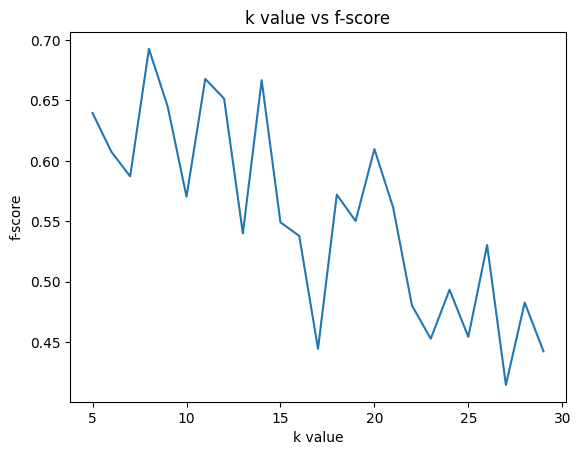

In [127]:
k_values = range(5, 30)
scores = []

for k in k_values:
    k_scores = []
    for i in range(10):
        k_scores.append(get_scores(k)[2][0])
    scores.append(np.array(k_scores).mean())

plt.figure()
plt.title('k value vs f-score')
plt.ylabel('f-score')
plt.xlabel('k value')
plt.plot(k_values, scores)
plt.show()

### Step 5: Build 10 kNN models with a k value of 8 and report results

In [141]:
results = []
for i in range(10):
    scores = get_scores(8)
    results.append(scores)

f_scores = [result[2][0] for result in results]
mean_f = np.array(f_scores).mean()

print('Mean f-score of all models: ', mean_f, '\n')

print('Individual Model Scores: ')
for i in range(10):
    print('\tModel', i+1, ': precision =', results[i][0][0], 'recall =', results[i][1][0], 'f-score =', results[i][2][0])

Mean f-score of all models:  0.7282764473702016 

Individual Model Scores: 
	Model 1 : precision = 1.0 recall = 0.7692307692307693 f-score = 0.8695652173913044
	Model 2 : precision = 1.0 recall = 0.6363636363636364 f-score = 0.7777777777777778
	Model 3 : precision = 1.0 recall = 0.42857142857142855 f-score = 0.6
	Model 4 : precision = 0.8571428571428571 recall = 0.6 f-score = 0.7058823529411764
	Model 5 : precision = 0.9090909090909091 recall = 0.625 f-score = 0.7407407407407406
	Model 6 : precision = 1.0 recall = 0.7272727272727273 f-score = 0.8421052631578948
	Model 7 : precision = 1.0 recall = 0.5555555555555556 f-score = 0.7142857142857143
	Model 8 : precision = 1.0 recall = 0.45454545454545453 f-score = 0.625
	Model 9 : precision = 0.8 recall = 0.5714285714285714 f-score = 0.6666666666666666
	Model 10 : precision = 0.8333333333333334 recall = 0.6666666666666666 f-score = 0.7407407407407408
